### Importing functions

In [30]:
from sklearn.datasets import load_digits
from matplotlib.pyplot import imshow,title,show

### Self made library for neural networks

In [31]:
from numpy import *
from graphviz import Digraph
from IPython.display import display,Image

g = Digraph("Network")
NodeCollection = []
Variables = []
counter = 0
dt = 0.01
class Node:
    name = None
    COLOR = "black"
    def __init__(self,name=None,draw=True):
        global counter,NodeCollection
        self.value = None
        self.outputNodes = []
        self.inputNodes = []
        self.id = counter
        self.draw = draw
        if self.name==None and name == None:
            self.name = "node "+str(self.id)
        elif name!=None:
            self.name = name
        if draw:
            g.node(str(self.id),self.name,color=self.COLOR)
        NodeCollection.append(self)
        counter += 1
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n"
    def __add__(self,other):
        return Add([self,toNode(other)],"+")
    def __mul__(self,other):
        return Mul([self,toNode(other)],"*")
    def __pow__(self,other):
        return Pow([self,toNode(other)],"**")
    def __div__(self,other):
        return self*(other**(-1))
    def __neg__(self):
        return Neg([self],"-")
    def __sub__(self,other):
        return self + (-toNode(other))
    def recieve(self):
        self.grad = 0
        for n in self.outputNodes:
            DFDX = n.dfdx_value[self.id]
            GRAD = n.grad
            #print("recievong from",n.id,"aka",n.name)
            #print("DFDX",DFDX.shape)
            #print("GRAD",GRAD.shape)
            if len(DFDX.shape)==1 and GRAD.shape==(1,DFDX.shape[0]) and len(self.value.shape)==2:
                self.grad += GRAD.T @ DFDX[newaxis,:]
            elif DFDX.shape==(1,) or GRAD.shape ==(1,):
                self.grad += GRAD*DFDX
            else:
                #self.grad += dot(GRAD,DFDX)
                self.grad += GRAD @ DFDX
class Function(Node):
    COLOR = "green"
    f = None
    dfdx = None
    dfdx_value = None
    def __init__(self,inputNodes,name=None,draw=True):
        super().__init__(name,draw)
        for n in inputNodes:
            if self.draw and n.draw:
                g.edge(str(n.id),str(self.id))
            n.outputNodes.append(self)
        self.inputNodes = inputNodes
        self.forward()
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n dfdx : \n{self.dfdx_value}\n"
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.dfdx_value = self.dfdx(self.inputs)
        self.grad = array([[1]])
    def backward(self):
        for n in self.inputNodes:
            n.recieve()
            n.backward()
class Variable(Node):
    COLOR = "red"
    def __init__(self,value,name=None,draw=True):
        super().__init__(name,draw)
        self.value = value
        self.grad = array([[1]])
        Variables.append(self)
    def backward(self):
        pass
    def forward(self):
        global dt
        self.grad.resize(self.value.shape)
        self.value = self.value - self.grad*dt
class Constant(Variable):
    COLOR="black"
    def recieve(self):
        pass
    def forward(self):
        pass
def toNode(other,draw=True):
    name = None
    if isinstance(other,Node):
        return other
    if type(other) != ndarray:
        if type(other) != iterable:
            name = str(other)
            other = array([other])
        else:
            other = array(other)
    return Constant(other,name,draw)
class Add(Function):
    name = "+"
    def f(self,inputs):
        S = 0
        for id in inputs:
            S = S + inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            n = prod(inputs[id].shape)
            if n>1:
                G[id] = identity(n)
            else:
                G[id] = ones(prod(self.value.shape))[:,newaxis]
        return G
class Mul(Function):
    name = "*"
    def f(self,inputs):
        S = 1
        for id in inputs:
            S = S*inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            S = 1
            for Id in inputs:
                if Id == id:
                    continue
                S = S*inputs[Id]
            S = S.flatten()
            n = prod(inputs[id].shape)
            if n > 1:
                m, = S.shape
                if m > 1:
                    S = diag(S)
                else :
                    S = S * identity(n)
            else:
                S = S[:,newaxis]
            G[id] = S
        return G
class Exp(Function):
    name = "exp"
    def f(self,inputs):
        return exp(next(iter(inputs.values())))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = prod(x.shape)
        x = exp(x)
        x = x.flatten()
        if n>1:
            return {id:diagflat(x)}
        return {id:x[:,newaxis]}
class Pow(Function):
    name = "**"
    def f(self,inputs):
        x,n = inputs.values()
        return x**n
    def dfdx(self,inputs):
        ids = list(inputs.keys())
        x,n = inputs.values()
        m = prod(x.shape)
        if m > 1:
            return {ids[0]:diagflat(n*x**(n-1))}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
        return {ids[0]:(n*x**(n-1)).flatten()[:,newaxis]}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
class Neg(Function):
    name = "-"
    def f(self,inputs):
        return -next(iter(inputs.values()))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = int(prod(x.shape))
        #if n>1:
        #    return {id:-identity(n)}
        #return {id:-array([1])}
        return {id:-identity(n)}
class Dot(Function):
    name = "."
    def f(self,inputs):
        x,y = inputs.values()
        d = dot(x,y)
        if len(d.shape)>0:
            return d
        return array([d])
    def dfdx(self,inputs):
        id1,id2 = inputs.keys()
        x,y = inputs.values()
        if len(x.shape) == 1:
            x = x[newaxis,:]
            y = y[newaxis,:]
        return {id1:y,id2:x}
class Sum(Function):
    name = "sum"
    def f(self,inputs):
        x, = inputs.values()
        if len(x.shape)==1:
            return array([sum(x)])
        else:
            return array([[sum(x)]])
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        s = x.shape
        if len(s)==1:
            return {id:ones((1,s[0]))}
        else :
            return {id:ones(s)}
class Sin(Function):
    name = "sin"
    def f(self,inputs):
        x, = inputs.values()
        return sin(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(cos(x))}
class Cos(Function):
    name = "cos"
    def f(self,inputs):
        x, = inputs.values()
        return cos(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(sin(x))}
class MatFunc(Function):
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.grad = array([[1]])
    def __init__(self, inputNodes, name=None, draw=True):
        super().__init__(inputNodes, name, draw)
        for n in self.inputNodes:
            if isinstance(n,MatFunc):
                n.recieve = n.send
            else:
                n.recieve = lambda:None
    def recieve(self):
        super().recieve()
        self.send()
class MatMul(MatFunc):
    name = "@"
    def f(self,inputs):
        W,X = inputs.values()
        return W @ X
    def send(self):
        w,x = self.inputNodes
        W = w.value
        X = x.value
        G = self.grad
        w.grad = G @ X.T
        x.grad = W.T @ G
class SigmM(MatFunc):
    name = "Sigma"
    def f(self,inputs):
        X, = inputs.values()
        return sigmoid(X)
    def send(self):
        x, = self.inputNodes
        X = x.value
        G = self.grad
        sig = sigmoid(X)
        x.grad = G*(sig**2/exp(X))
class SqNorM(MatFunc):
    name = "Norm"
    def f(self,inputs):
        X, = inputs.values()
        return array([linalg.norm(X,'fro')])**2
    def send(self):
        x = self.inputNodes[0]
        x.grad = 2*x.value*self.grad
class DotM(MatFunc):
    name = "."
    def f(self,inputs):
        X,Y = inputs.values()
        return sum(X*Y)
    def send(self):
        x,y = self.inputNodes
        X,Y = x.value,y.value
        G = self.grad # assumed to be a scalar
        x.grad = Y*G
        y.grad = X*G
class AddM(MatFunc):
    name = "+"
    def f(self,inputs):
        S = 0
        for X in inputs.values():
            S = S + X
        return S
    def send(self):
        for n in self.inputNodes:
            if len(n.value.shape) == 1 or n.value.shape[0] == 1:
                n.grad = sum(self.grad,axis=0)
            else :
                n.grad = self.grad
class MulM(MatFunc):
    name = "*"
    def f(self,inputs):
        S = 1
        for X in inputs.values():
            S = S * X
        return S
    def send(self):
        for n in self.inputNodes:
            for m in self.inputNodes:
                S = 1
                if m is not n:
                    S *= m.value
            if len(n.value.shape) == 2 and n.value.shape[1] == 1:
                n.grad = sum(self.grad*S,axis=1)[:,newaxis]
            elif len(n.value.shape)==1:
                n.grad = sum(self.grad*S,axis=0)[newaxis,:]
            else :
                n.grad = self.grad*S
class Normalise(MatFunc):
    name = "normalise"
    def f(self,inputs):
        X, = inputs.values()
        return X/sum(X,axis=1)[:,newaxis]
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        s = sum(X,axis=1)[:,newaxis]
        G = self.grad
        x.grad = (G/s)*(1-(X/s))
class ExpM(MatFunc):
    name = "exp"
    def f(self,inputs):
        X, = inputs.values()
        return exp(X)
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        eX = exp(X)
        G = self.grad
        x.grad = G*eX
class SoftMax(MatFunc):
    name = "SM"
    def f(self,inputs):
        yp, = inputs.values()
        mu = amax(yp,axis=1)[:,newaxis]
        yps = yp-mu
        ey = exp(yps)
        eys = sum(ey,axis=1)[:,newaxis]
        out = ey/eys
        return out
    def send(self):
        y_pred = self.inputNodes[0]
        yp = self.value
        G = self.grad
        out = yp - yp**2
        out = G*out
        y_pred.grad = out
class LogM(MatFunc):
    name = "log"
    def f(self,inputs):
        X, = inputs.values()
        out = log(X)
        if(out[0][0]==nan):
            print("overflow")
        return out
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        Xi = X**-1
        G = self.grad
        x.grad = G*Xi
class NegM(MatFunc):
    name = "-"
    def f(self,inputs):
        X, = inputs.values()
        return -X
    def send(self):
        x = self.inputNodes[0]
        x.grad = -self.grad
class PowM(MatFunc):
    name="**"
    def f(self,inputs):
        X,n = inputs.values()
        return X**n
    def send(self):
        x,n = self.inputNodes
        X = x.value
        n = n.value
        x.grad = self.grad*n*X**(n-1)
class SumM(MatFunc):
    name = "sum"
    def f(self,inputs):
        X, = inputs.values()
        return sum(X,axis=1)
    def send(self):
        x = self.inputNodes[0]
        x.grad = tile(self.grad[0][:,newaxis],x.value.shape[1])
class SUM(MatFunc):
    name = "SUM"
    def f(self,inputs):
        X, = inputs.values()
        return array([sum(X)])
    def send(self):
        x = self.inputNodes[0]
        x.grad = self.grad*ones(x.value.shape)

def CrossEntropy(inputNodes):
    data,prediction = inputNodes
    n = data.value.shape[0]
    m = data.value.shape[1]
    out = AddM([prediction,data,toNode(-1)])
    out = PowM([out,Constant(array([[2]]))])
    out = LogM([out])
    out = MulM([out,Constant(array([[1/n]]))])
    #one = ones((n,m))
    #one = Constant(one,"1")
    #out = DotM([out,one])
    out = SUM([out])
    out = Neg([out])
    return out
def Sigm(inputNode,name="S",draw=True):
    out = Neg([inputNode],None,False)
    out = Exp([out],None,False)
    out = Add([out,Constant(array([1]),None,False)],None,False)
    out = Pow([out,Constant(array([-1]),None,False)],name,True)
    if draw and inputNode.draw:
        g.edge(str(inputNode.id),str(out.id))
    return out
def Layer(X,pin,pout,name=None,bias=False,activation_func=SigmM,categorical=False):
    W = random.random((pin,pout))
    if categorical:
        W = W/pout
    W = Variable(W,"W")
    Y = MatMul([X,W])
    if bias:
        b = random.random(pout)
        b = Variable(b,"b")
        Y = AddM([Y,b]) 
    Y = activation_func([Y],name)
    return Y
def SqErM(inputNodes):
    yp,y = inputNodes
    myp = NegM([yp])
    er = AddM([myp,y])
    n = y.value.shape[0]
    er = MulM([er,Constant(array([[n**-0.5]]),"norm fact")])
    s = SqNorM([er],"L")
    return s
def perceptron(layer,draw=True):
    nl = []
    for n in layer :
        nl.append(Mul([n,Variable(random.random(1),None,False)],None,False))
    S = Add(nl,"+",False)
    S = Sigm(S,"P",draw)
    for n in layer:
        if draw and n.draw:
            g.edge(str(n.id),str(S.id))
    S.nl = nl
    return S
def SqEr(inputNodes,name="L",draw=True):
    x,y = inputNodes
    out = Neg([y],None,False)
    out = Add([x,out],None,False)
    two = Constant(array([2]),None,False)
    out = Pow([out,two],None,False)
    out = Sum([out],name,draw)
    for n in inputNodes:
        if draw and n.draw:
            g.edge(str(n.id),str(out.id))
    return out
def BacProp(show=False):
    global NodeCollection
    n = NodeCollection[-1]
    if isinstance(n,MatFunc):
        n.send()
    for i in range(len(NodeCollection)-2,-1,-1):
        n=NodeCollection[i]
        n.recieve()
        if show:
            print(n)
def forProp(show=False):
    global NodeCollection
    for i in range(len(NodeCollection)):
        n=NodeCollection[i]
        n.forward()
        if show:
            print(n)
def BackTrackAndDescend(iterations=100,alpha=2,dt_init=10**-2):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    i = 0
    for _ in range(iterations):
        dt = dt_init
        BacProp()
        oldL = L.value
        forProp()
        i += 1
        S = sum([(linalg.norm(n.grad))**2 for n in Variables])
        while (oldL-L.value)[0] >= 0.5*(dt)*S:
            dt *= alpha
            oldL = L.value
            forProp()
            i+= 1
        if oldL < L.value:
            dt = -dt
            forProp()
            dt = -dt
            i += -1
        if dt==dt_init:
            dt_init /= alpha
    print("after",L.value)
    print("i =",i)
def Descend(iterations=100):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    for i in range(iterations):
        BacProp()
        forProp()
    print("after",L.value)
def Reset():
    global g,NodeCollection,Variables,counter,dt
    g = Digraph("Network")
    del NodeCollection
    NodeCollection = []
    Variables = []
    counter = 0
    dt = 0.01
def Show(g,w=100):
    display(Image(g.pipe("png"),width=w))
def sigmoid(x):
    return 1/(1+exp(-x))

class PerceptronNet:
    def __init__(self,LS=[3,3,3]):
        Reset()
        n = LS.pop(0)
        layer0 = [Constant(ones(1)) for _ in range(n)]
        layers = [layer0]
        for n in LS:
            last_layer = layers[-1]
            layers.append([perceptron(last_layer) for _ in range(n)])
        P = perceptron(layers[-1])
        y = Constant(ones(1),"y")
        L = SqEr([P,y])
        self.y = y
        self.layer0 = layer0
        self.P = P
        self.L = L
        self.layers = layers
    def assign(self,X,y):
        if X.shape[1]!= len(self.layer0):
            print("Can't deal with this many variables.")
            return
        self.y.value = y
        for c in range(X.shape[1]):
            self.layer0[c].value = X[:,c]
        forProp()
    def predict(self):
        forProp()
        loss = self.L.value
        y_pred = self.P.value
        return y_pred,loss
class LayerNet:
    def __init__(self,X,y,middle=[3,3,3],bias=False,normalise=False,startbasis=True,categorical=False,lossFunc=SqErM):
        if isinstance(bias,bool):
            bias = [bias for _ in range(len(middle))]
        Reset()
        m = X.shape[1]
        n = y.shape[1]
        if normalise:
            mu = mean(X,axis=0)
            sdi = diag(var(X,axis=0)**(-0.5))
        X = Constant(X,"X")
        y = Constant(y,"y")
        self.y = y
        self.X = X
        if normalise:
            nmu = Constant(-mu,'b')
            sdi = Constant(sdi,"W")
            X = AddM([X,nmu],"shifted X")
            X = MatMul([X,sdi],"normalised X")
        out = Layer(X,m,middle[0],"layer 0",startbasis,categorical=categorical)
        for i in range(len(middle)-1):
            out = Layer(out,middle[i],middle[i+1],f"layer {i+1}",bias[i],categorical=categorical)
        if categorical:
            y_pred = Layer(out,middle[-1],n,'y_pred',bias[-1],activation_func=SoftMax,categorical=True)
        else:
            y_pred = Layer(out,middle[-1],n,'y_pred',bias[-1],activation_func=SigmM)
        L = lossFunc([y_pred,y])
        self.y_pred = y_pred
        self.L = L
    def predict(self,X,y,testName = "",categorical=True):
        self.X.value = X
        self.y.value = y
        forProp()
        y_pred = self.y_pred.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy on test ",testName," : ",round(mean(around(y_pred)==y)*100,2),"%")
        return y_pred
    def train(self,iterations=100,dtvalue=0.01,categorical=True):
        global dt
        dtold = dt
        dt = dtvalue
        y_pred = self.y_pred.value
        y = self.y.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy before training : ",round(mean(around(y_pred)==y)*100,2),"%")
        Descend(iterations)
        dt = dtold
        y_pred = self.y_pred.value
        y = self.y.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy on training : ",round(mean(around(y_pred)==y)*100,2),"%")


### loading the data

In [32]:
D = load_digits()
print(D.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [33]:
X,y = D.data,D.target
o = 1003
Xo,yo = X[o],y[o]
mu = mean(X,axis=0)
sd = var(X,axis=0)**0.5
sli = (sd!=0)
X = X[:,sli]
mu = mu[sli]
sd = sd[sli]
X = (X-mu)/sd
X,Xt = X[:1000],X[1000:1500]
y,yt = y[:1000],y[1000:1500]

### Converting the data

In [34]:
Y = zeros((y.shape[0],10))
Yt = zeros((yt.shape[0],10))
for i in range(y.shape[0]):
    Y[i][y[i]]=1
for i in range(yt.shape[0]):
    Yt[i][yt[i]]=1

### Creating the neural net

We are using a neural net with single hidden layer with 20 perceptrons, softmax activation function for last layer and cross entropy loss function.

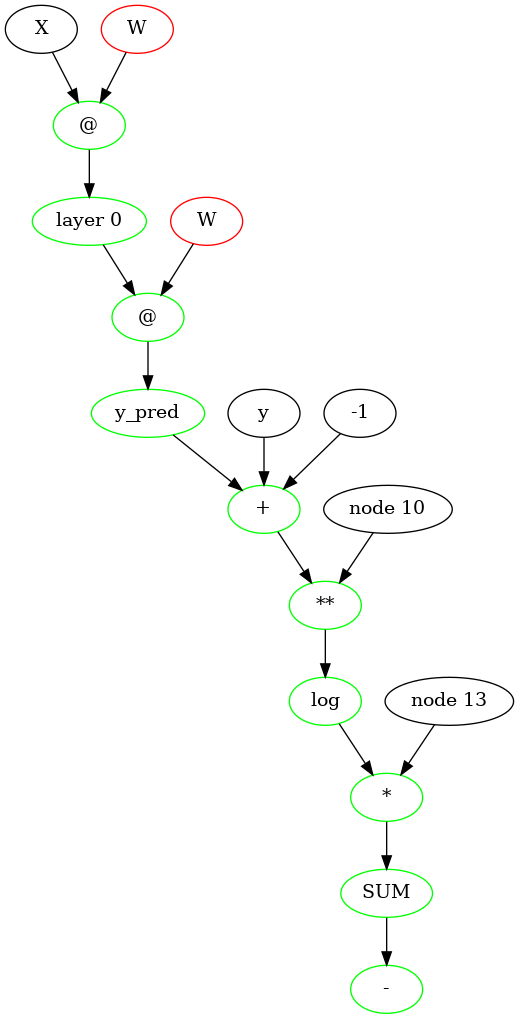

In [35]:
net = LayerNet(X,Y,[20],False,False,False,True,CrossEntropy)
Show(g,200)

### Training the neural net

In [36]:
net.train(1000,0.1,True)

accuracy before training :  9.9 %
before [6.50812141]


after [0.36691863]
accuracy on training :  98.9 %


### prediction for test data

In [37]:
yp = net.predict(Xt,Yt,'500')

accuracy on test  500  :  95.6 %


### prediction for a single input

accuracy on test  single  :  100.0 %


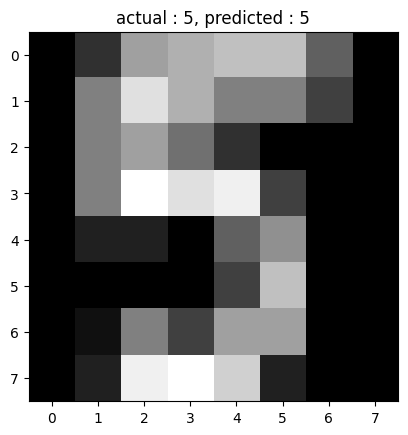

In [38]:
x,y = Xt[o-1000:o-999,:],Yt[o-1000:o-999,:]
yp = net.predict(x,y,"single")
imshow(reshape(Xo,(8,8)),'gray')
title(f"actual : {yo}, predicted : {yp[0]}")
show()